# Рекомендация тарифов

Задача

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы. Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Постройте модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте *accuracy* на тестовой выборке самостоятельно.

## Открываем и изучаем файл

In [ ]:
Импортируем библиотеки

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.dummy import DummyClassifier
from joblib import dump
from time import time
import numpy as np
import seaborn as sns
import operator
import matplotlib.pyplot as plt

открываем файл

In [ ]:
df = pd.read_csv('/datasets/users_behavior.csv')
df.info

<bound method DataFrame.info of       calls  minutes  messages   mb_used  is_ultra
0      40.0   311.90      83.0  19915.42         0
1      85.0   516.75      56.0  22696.96         0
2      77.0   467.66      86.0  21060.45         0
3     106.0   745.53      81.0   8437.39         1
4      66.0   418.74       1.0  14502.75         0
...     ...      ...       ...       ...       ...
3209  122.0   910.98      20.0  35124.90         1
3210   25.0   190.36       0.0   3275.61         0
3211   97.0   634.44      70.0  13974.06         0
3212   64.0   462.32      90.0  31239.78         0
3213   80.0   566.09       6.0  29480.52         1

[3214 rows x 5 columns]>

In [ ]:
print('Количество абонентов на тарифе "ультра"', df['is_ultra'].value_counts()[1])
print('Количество абонентов на тарифе "смарт"', df['is_ultra'].value_counts()[0])

Количество абонентов на тарифе "ультра" 985
Количество абонентов на тарифе "смарт" 2229


Построим таблицу корреляции

In [ ]:
df.corr()

,calls,minutes,messages,mb_used,is_ultra
calls,1.000000,0.982083,0.177385,0.286442,0.207122
minutes,0.982083,1.000000,0.173110,0.280967,0.206955
messages,0.177385,0.173110,1.000000,0.195721,0.203830
mb_used,0.286442,0.280967,0.195721,1.000000,0.198568
is_ultra,0.207122,0.206955,0.203830,0.198568,1.000000


Визуализируем таблицу корреляции

<AxesSubplot:>

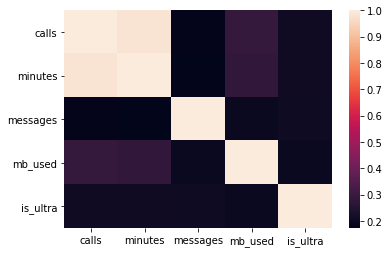

In [ ]:
sns.heatmap(df.corr())

## Разобьем данные на выборки

In [ ]:
df_train, df_other = train_test_split(df, test_size=0.4, random_state=12345) #делим датасет на
df_test, df_valid = train_test_split(df_other, test_size=0.5, random_state=12345)
df_train.shape, df_test.shape, df_valid.shape

((1928, 5), (643, 5), (643, 5))

In [ ]:
#сохраняем признаки для обучающей выборки:
features = df_train.drop(['is_ultra'], axis=1)
target = df_train['is_ultra']
#сохраняем признаки для тестовой выборки:
features_test = df_test.drop(['is_ultra'], axis=1)
target_test = df_test['is_ultra']
#сохраняем признаки для валидационной выборки:
features_valid = df_valid.drop(['is_ultra'], axis=1)
target_valid = df_valid['is_ultra']

## Исследуем модели

Дерево решений

In [ ]:
for depth in range(1,6):
    model = DecisionTreeClassifier(random_state=12345, max_depth = depth) #обучаем модель с заданной глубиной
    model.fit(features, target) #обучаем модель
    predictions_valid = model.predict(features_valid) #получаем предсказания модели
    print("max_depth =", depth, ": ", end='')
    #print(accuracy_score(target, predictions))
    print(accuracy_score(target_valid, predictions_valid)) #посмотрим на качество модели

max_depth = 1 : 0.7356143079315708
max_depth = 2 : 0.7744945567651633
max_depth = 3 : 0.7791601866251944
max_depth = 4 : 0.7744945567651633
max_depth = 5 : 0.7838258164852255


depth: (valid sample) 7, (teach sample) 24;
accuracy: (valid sample) 0.7994, (teach sample) 0.7309


<AxesSubplot:>

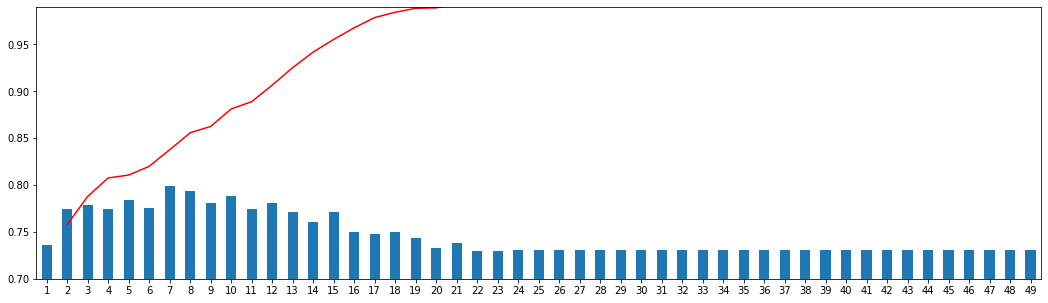

In [ ]:
depth_dt={}
depth_dt_teach_sample={}
for depth in range(1,50):
    model_tree = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model_tree.fit(features, target)
    predictions = model_tree.predict(features_valid)
    accuracy = round(accuracy_score(target_valid, predictions),4)
    accuracy_teach_sample = round(model_tree.score(features, target),4)
    depth_dt[depth] = accuracy
    depth_dt_teach_sample[depth] = accuracy_teach_sample

print('depth: (valid sample) {}, (teach sample) {};\n\
accuracy: (valid sample) {:.4f}, (teach sample) {:.4f}'\
      .format(\
              max(depth_dt.items(),key=operator.itemgetter(1))[0],\
              max(depth_dt_teach_sample.items(),key=operator.itemgetter(1))[0],\
              depth_dt[max(depth_dt.items(),key=operator.itemgetter(1))[0]],\
              depth_dt[max(depth_dt_teach_sample.items(),key=operator.itemgetter(1))[0]],\
             )\
     )
#plt.figure(figsize=(20,5))

pd.Series(depth_dt).plot.bar(ylim=(.7,.85),figsize=(18,5))
pd.Series(depth_dt_teach_sample).plot.line(ylim=(.7,.99),figsize=(18,5), color='red')

По графику можно сделать вывод, что при глубине решающего дерева больше 10 - эффективность модели падает и наступает переобучение.

In [ ]:
#Случайный лес
best_model_rf = None
best_result = 0
for est in range(1, 100):
    model_rf = RandomForestClassifier(random_state=12345, n_estimators=est, max_features="sqrt") #обучите модель с заданным количеством деревьев
    model_rf.fit(features, target) #обучаем модель
    result = model_rf.score(features_valid, target_valid) # посчитайте качество модели на валидационной выборке
    if result > best_result:
        best_model_rf = model_rf # сохраните наилучшую модель
        best_result = result #  сохраните наилучшее значение метрики accuracy на валидационных данных

print("Accuracy наилучшей модели на валидационной выборке:", best_result)

Accuracy наилучшей модели на валидационной выборке: 0.7962674961119751


Логистическая регрессия

In [ ]:
model_lr = LogisticRegression(random_state=12345, solver='lbfgs', max_iter=1000)
model_lr.fit(features, target) #обучаем модель
print(accuracy_score(target_valid, predictions_valid)) #посмотрим на качество модели

0.7838258164852255


Случайный лес показал точность 0,794, подберем лучшие параметры методом GridSearchCV.

Gridsearch на валидационной выборке.
Зададим параметры

In [ ]:
param_grid = {'n_estimators': [50, 100, 200, 300],
              'min_samples_leaf': [1, 5, 10],
              'max_depth': [2, 4, 6, 8, 10],
              'max_features': ['auto', 'sqrt'],
              'bootstrap': [True, False]}
model_gridsearch = GridSearchCV(
estimator=model_rf,
param_grid=param_grid,
scoring='accuracy',
n_jobs=4,
cv=5,
refit=True,
return_train_score=True)
# Напишем текущее время
start = time()
# Обучим модель
model_gridsearch.fit(features, target)
# Напечатаем время и количество моделей
print("GridSearchCV занимает %.2f секунд для проверки %d моделей." % ((time() - start), len(model_gridsearch.cv_results_['params'])))
# Выводим результат
y_pred_grid = model_gridsearch.predict(features_valid)
accuracy_grid = accuracy_score(target_valid, y_pred_grid)
print(model_gridsearch.best_params_)
print(model_gridsearch.best_estimator_)
print(model_gridsearch.best_score_)

/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForest

GridSearchCV занимает 693.51 секунд для проверки 240 моделей.
{'bootstrap': True, 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'n_estimators': 100}
RandomForestClassifier(max_depth=10, max_features='auto', random_state=12345)
0.8210658771280533


## Выводы:
Я использовала модели:
- Дерево Решения с параметрами(random_state=12345, depth = 1-6),
- Случайный Лес с параметрами(random_state=12345, n_estimators=est, max_features="sqrt"),
- Логистическую регрессию с параметрами - (random_state=12345, solver='lbfgs', max_iter=1000).

Протестировав модели на валидационной выборке мы видим, что случайный лес выдает наиболее высокий accuracy - 0.796. Так что на тестовой выборке будем проверять эту модель.

## Проверка модели на тестовой выборке

In [ ]:
test_predications = model_gridsearch.best_estimator_.predict(features_test)
best_result = accuracy_score(test_predications, target_test)
print("Accuracy наилучшей модели на тестовой выборке:", best_result)


Accuracy наилучшей модели на тестовой выборке: 0.7947122861586314


Случайный лес показал точность 0,794, подберем лучшие параметры методом GridSearchCV.

## Выводы:
При проверке на тестовой выборке модель RandomForest показала accuracy 0.79, что соотвествует поставленной задаче (accuracy > 0.75). Я решила улучшить точность модели, для этого использовала метод gridsearch, однако, он показал, что более улучшить точность на тестовой выборке не получится.
Для предложения тарифа абонентам рекомендуется использовать модель "Случайный лес" с параметрами, представленными в проекте.


## Проверка модели на адекватность

In [ ]:
dummy = DummyClassifier(strategy="most_frequent") #записываем модель в переменную
dummy.fit(features, target) #обучаем модель
print("Accuracy наилучшей модели на тестовой выборке:", dummy.score(features_valid, target_valid)) #выводи результат


Accuracy наилучшей модели на тестовой выборке: 0.6842923794712286


## Выводы:
DummyClassifier показывает точность 0.68. Обученная модель - 0.79, то есть модель адекватна.